<a href="https://colab.research.google.com/github/BhaskarBiswas/Applied_DataScience_Python_UMichigan/blob/master/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd


Getting files from local system

In [8]:
from google.colab import files
import io

In [4]:
uploaded = files.upload()

Saving comp_classification_train.csv to comp_classification_train.csv


In [5]:
train_file = pd.read_csv(io.BytesIO(uploaded["comp_classification_train.csv"]))

In [6]:
uploaded = files.upload()

Saving comp_classification_test.csv to comp_classification_test.csv


In [9]:
test_file = pd.read_csv(io.BytesIO(uploaded['comp_classification_test.csv']))

NameError: ignored

In [ ]:
train_file.head()



,index,tcin,comp_title,image_url,brand,tgt_item_type,department_name,division_name
0,0,11341285,Oprah's Book Club: Night (Hardcover),NaN,Macmillan,Books,BOOKS/MAGAZINES,ENTERTAINMENT
1,4,11825477,"Who Was Martin Luther King, Jr.?",NaN,Readerlink,Books,BOOKS/MAGAZINES,ENTERTAINMENT
2,5,11944343,ONLINE ONLY TIME'S MAKIN CHANGES:,NaN,NaN,music,TCOM MUSIC 1,ENTERTAINMENT
3,6,12615521,Bausch & Lomb Biotrue for Soft Contact Lenses ...,https://i5.walmartimages.com/asr/c35eee8a-f7bc...,Biotrue,Contact Lens Solution,OTC-PERSONAL CARE,OTC
4,7,12834908,Burt's Bees Peach and Willow Bark Exfoliating ...,https://i5.walmartimages.com/asr/af8e1166-bad5...,Burt's Bees,Facial Cleansers,SKIN/BATH/FRAGRANCES,BEAUTY


In [ ]:
test_file.head()

,index,tcin,comp_title,image_url,brand,tgt_item_type,department_name,division_name
0,57247,51022003,3D PUZZLE 3D CRYSTAL PUZZLE,https://i5.walmartimages.com/asr/4218ec5e-047b...,Bepuzzled,3D Puzzles,GAMES/DIECAST/ACTION FIGURES,TOYS
1,163415,51022024,3D PUZZLE 3D CRYSTAL PUZZLE,NaN,Bepuzzled,3D Puzzles,GAMES/DIECAST/ACTION FIGURES,TOYS
2,148979,80432024,DELUXE 3D CRYSTAL PU,NaN,Bepuzzled,3D Puzzles,GAMES/DIECAST/ACTION FIGURES,TOYS
3,83203,81306355,OWL WHITE,https://i5.walmartimages.com/asr/655b23e3-c3bd...,University Games,3D Puzzles,GAMES/DIECAST/ACTION FIGURES,TOYS
4,42853,80432027,ONLINE: PUZZLE DELUXE 3D CRYSTAL,https://i5.walmartimages.com/asr/0c9212c7-4b32...,Bepuzzled,3D Puzzles,GAMES/DIECAST/ACTION FIGURES,TOYS


In [4]:
train_na_removed = train_file.dropna() 
test_na_removed = test_file.dropna() 

NameError: ignored

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
from tqdm import tqdm_notebook
np.random.seed(500)
import warnings
from sklearn.utils.testing import ignore_warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(ngram_range=(1,3))
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import nltk
nltk.download('stopwords')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
def preprocessing(col,h_pct=1,l_pct=1):
    '''
    Cleans the text in the input column
    Parameters
    ----------
    col : pandas.core.series.Series
        The column which needs to be processed
    h_pct : float (default = 1)
        The percentage of high frequency words to remove from the corpus
    l_pct : float (default = 1)
        The percentage of low frequency words to remove from the corpus
    
    Returns
    -------
    cleaned text series
    '''
    #Lower case
    lower = col.apply(str.lower)
    
    #Removing HTML tags
    rem_html = lower.apply(lambda x: x.replace('#39;', "'").replace('amp;', '&')
                             .replace('#146;', "'").replace('nbsp;', ' ').replace('#36;', '$')
                             .replace('\\n', "\n").replace('quot;', "'").replace('<br />', " ")
                             .replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.')
                             .replace(' @-@ ','-').replace('\\', ' \\ ').replace('&lt;','<')
                             .replace('&gt;', '>'))
    
    #Stemming
    from nltk.stem import SnowballStemmer
    stem = SnowballStemmer('english')
    stemmed = rem_html.apply(lambda x: ' '.join(stem.stem(word) for word in str(x).split()))
    
    #removing punctuation
    import re
    rem_punc = stemmed.apply(lambda x: re.sub(r'[^\w\s]',' ',x))
    
    #removing stopwords and extra spaces
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    rem_stopwords = rem_punc.apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
    
    #removing numbers
    rem_num = rem_stopwords.apply(lambda x: " ".join(x for x in x.split() if not x.isdigit()))
    
    #remove words having length=1
    rem_lngth1 = rem_num.apply(lambda x: re.sub(r'[^\w\s]',' ',x))
    
    if h_pct != 0:
        #removing the top $h_pct of the most frequent words 
        high_freq = pd.Series(' '.join(rem_lngth1).split()).value_counts()[:int(pd.Series(' '.join(rem_lngth1).split()).count()*h_pct/100)]
        rem_high = rem_lngth1.apply(lambda x: " ".join(x for x in x.split() if x not in high_freq))
    else:
        rem_high = rem_lngth1
    
    if l_pct != 0:
        #removing the top $l_pct of the least frequent words
        low_freq = pd.Series(' '.join(rem_high).split()).value_counts()[:-int(pd.Series(' '.join(rem_high).split()).count()*l_pct/100):-1]
        rem_low = rem_high.apply(lambda x: " ".join(x for x in x.split() if x not in low_freq))
    else:
        rem_low = rem_high
    
    return rem_low

In [18]:
train_na_removed['comp_title_cleaned'] = preprocessing(train_na_removed['comp_title'],0,1)
test_na_removed['comp_title_cleaned'] = preprocessing(test_na_removed['comp_title'],0,1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [2]:
%matplotlib inline
def model_fit(df_train, df_test, model, y_var_column, x_var_column, verbose=False):
    '''
    Takes the dataframe, and returns asset tag predictions for the stories
    Parameters
    ----------
    df_train : pandas.core.frame.DataFrame
        Train dataset
    df_train : pandas.core.frame.DataFrame
        Test dataset
    verbose : boolean (default: False)
        Verbosity of the output. True = all outputs, False = no outputs
    y_var_column : string
        Name of the y column
    x_var_column : string
        Name of the x column
            
    Returns
    -------
    preds : pandas.core.series.Series
        Column with the predicted asset class
    acc : float
        Accuracy of the predictions on the test set
    model : the trained model
    '''
    
 

    X_train = df_train[x_var_column]
    y_train = df_train[y_var_column]

    X_test = df_test[x_var_column]
    y_test = df_test[y_var_column]
    
    bow_xtrain = bow.fit_transform(X_train)
    bow_xtest = bow.transform(X_test)
    model.fit(bow_xtrain,y_train)
    preds = model.predict(bow_xtest)
    acc = accuracy_score(y_test,preds)*100

    print('Accuracy: {0:.2f}%'.format(acc))

    '''
    if verbose:
        labels = list(df_train[y_var_column].unique())
        labels.sort()
        plt.figure(figsize=(14,14))
        sns.heatmap(confusion_matrix(y_test,preds),cbar=False,annot=True,square=True,xticklabels=labels,yticklabels=labels,fmt='d')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.yticks(rotation=0)
        plt.show()
        print(classification_report(y_test,preds))
        print('Accuracy: {0:.2f}%'.format(acc))
    '''
    return preds, acc, model

Models to predict division of the item

In [3]:
from sklearn.linear_model import LogisticRegression
preds_abc, acc_abc, abc = model_fit(test_na_removed, test_na_removed, LogisticRegression(), 'division_name', 'comp_title_cleaned', verbose=True)

NameError: ignored

In [ ]:
from sklearn.naive_bayes import MultinomialNB
preds_abc, acc_abc, abc = model_fit(test_na_removed, test_na_removed, MultinomialNB(), 'division_name', 'comp_title_cleaned', verbose=True)

In [47]:
from sklearn.ensemble import RandomForestClassifier
preds_abc, acc_abc, abc = model_fit(train_na_removed, test_na_removed, RandomForestClassifier(), 'division_name', 'comp_title_cleaned', verbose=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Number of words in corpus before processing: 548353
Number of words in corpus after processing: 369367 (67%)
Accuracy: 88.38%


In [21]:
from sklearn.svm import LinearSVC
preds_abc, acc_abc, abc = model_fit(train_na_removed, test_na_removed, LinearSVC(), 'division_name', 'comp_title_cleaned', verbose=True)

Accuracy: 93.36%


In [ ]:
from sklearn.svm import SVC
preds_abc, acc_abc, abc = model_fit(train_na_removed, test_na_removed, SVC(), 'division_name', 'comp_title_cleaned', verbose=True)

In [16]:
from sklearn.neural_network import MLPClassifier
preds_abc, acc_abc, abc = model_fit(train_na_removed, test_na_removed, MLPClassifier(), 'division_name', 'comp_title_cleaned', verbose=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Number of words in corpus before processing: 112061
Number of words in corpus after processing: 92776 (83%)
Accuracy: 99.89%


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Accuracy: 99.70%


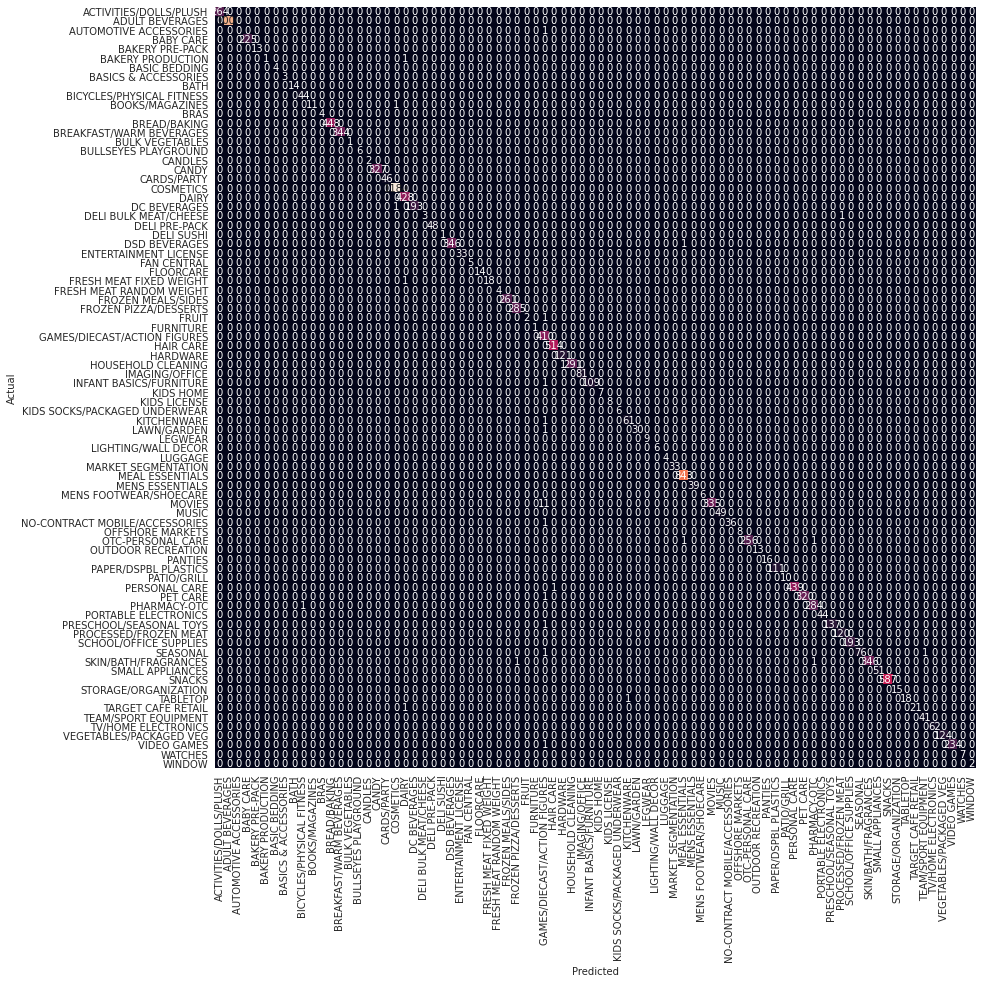

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                precision    recall  f1-score   support

        ACTIVITIES/DOLLS/PLUSH       1.00      1.00      1.00       264
               ADULT BEVERAGES       1.00      1.00      1.00      1006
        AUTOMOTIVE ACCESSORIES       0.00      0.00      0.00         1
                     BABY CARE       1.00      1.00      1.00       225
               BAKERY PRE-PACK       1.00      1.00      1.00        13
             BAKERY PRODUCTION       1.00      0.50      0.67         2
                 BASIC BEDDING       1.00      1.00      1.00         4
          BASICS & ACCESSORIES       1.00      1.00      1.00         3
                          BATH       1.00      1.00      1.00        14
     BICYCLES/PHYSICAL FITNESS       0.98      1.00      0.99        44
               BOOKS/MAGAZINES       1.00      0.92      0.96        12
                          BRAS       1.00      1.00      1.00         4
                  BREAD/BAKING       1.00      1.00      1.00  

In [28]:
from sklearn.linear_model import LogisticRegression
preds_abc, acc_abc, abc = model_fit(test_na_removed, test_na_removed, LogisticRegression(), 'department_name', 'comp_title_cleaned', verbose=True)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
preds_abc, acc_abc, abc = model_fit(test_na_removed, test_na_removed, MultinomialNB(), 'department_name', 'comp_title_cleaned', verbose=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
preds_abc, acc_abc, abc = model_fit(train_na_removed, test_na_removed, RandomForestClassifier(), 'department_name', 'comp_title_cleaned', verbose=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Number of words in corpus before processing: 548353
Number of words in corpus after processing: 369367 (67%)
Accuracy: 88.38%


In [ ]:
from sklearn.svm import LinearSVC
preds_abc, acc_abc, abc = model_fit(train_na_removed, test_na_removed, LinearSVC(), 'department_name', 'comp_title_cleaned', verbose=True)

Accuracy: 93.36%


In [ ]:
from sklearn.svm import SVC
preds_abc, acc_abc, abc = model_fit(train_na_removed, test_na_removed, SVC(), 'department_name', 'comp_title_cleaned', verbose=True)

In [ ]:
from sklearn.neural_network import MLPClassifier
preds_abc, acc_abc, abc = model_fit(train_na_removed, test_na_removed, MLPClassifier(), 'department_name', 'comp_title_cleaned', verbose=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Number of words in corpus before processing: 112061
Number of words in corpus after processing: 92776 (83%)
Accuracy: 99.89%


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [1]:
from sklearn.linear_model import LogisticRegression
preds_abc, acc_abc, abc = model_fit(test_na_removed, test_na_removed, LogisticRegression(), 'tgt_item_type', 'comp_title_cleaned', verbose=True)

NameError: ignored

In [ ]:
from sklearn.naive_bayes import MultinomialNB
preds_abc, acc_abc, abc = model_fit(test_na_removed, test_na_removed, MultinomialNB(), 'tgt_item_type', 'comp_title_cleaned', verbose=True)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
preds_abc, acc_abc, abc = model_fit(train_na_removed, test_na_removed, RandomForestClassifier(), 'tgt_item_type', 'comp_title_cleaned', verbose=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Number of words in corpus before processing: 548353
Number of words in corpus after processing: 369367 (67%)
Accuracy: 88.38%


In [ ]:
from sklearn.svm import LinearSVC
preds_abc, acc_abc, abc = model_fit(train_na_removed, test_na_removed, LinearSVC(), 'tgt_item_type', 'comp_title_cleaned', verbose=True)

Accuracy: 93.36%


In [ ]:
from sklearn.svm import SVC
preds_abc, acc_abc, abc = model_fit(train_na_removed, test_na_removed, SVC(), 'tgt_item_type', 'comp_title_cleaned', verbose=True)

In [ ]:
from sklearn.neural_network import MLPClassifier
preds_abc, acc_abc, abc = model_fit(train_na_removed, test_na_removed, MLPClassifier(), 'tgt_item_type', 'comp_title_cleaned', verbose=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Number of words in corpus before processing: 112061
Number of words in corpus after processing: 92776 (83%)
Accuracy: 99.89%


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>